In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random

In [27]:
def load_data(categories=4):
    # get random categories
    dir_list = []
    for dirs in os.listdir("caltech-101/101_ObjectCategories/"):
        dir_list.append(os.path.join("caltech-101/101_ObjectCategories", dirs))
        
    random.Random(5).shuffle(dir_list)      
    random_categories = dir_list[:categories] 
    
    data = []
    
    #get images from each category
    for category in random_categories:
        # get files in each category
        for file in os.listdir(category):
            im = cv2.imread(os.path.join(category, file))
            gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
            data.append((gray, category.split("/")[-1]))
            
    # shuffle data and split into train and test
    random.Random(4).shuffle(data)
    test = data[:int(len(data)/2)]
    train = data[int(len(data)/2):]
    
    return train, test
        
train, test = load_data()

print(len(train))
print(len(test))

283
283


In [25]:
# def load_data(categories=4):
#     #get 5 random categories
#     dir_list = []
#     for dirs in os.listdir("caltech-101/101_ObjectCategories/"):
#         dir_list.append(os.path.join("caltech-101/101_ObjectCategories", dirs))
        
#     random.Random(5).shuffle(dir_list)      
#     random_categories = dir_list[:categories] 
    
#     data = {}
    
#     # get images for each category
#     for category in random_categories:
#         # get files in each category
#         for file in os.listdir(category):
#             im = cv2.imread(os.path.join(category, file))
#             key = category.split("/")[-1]
            
#             data[key] = data.get(key, []) + [im]
        
#     # split into train and test  
#     train = {} 
#     test = {} 
    
#     for key in data.keys():
#         random.Random(5).shuffle(data[key])
#         train[key] = data[key][:int(len(data[key])/2)]
#         test[key] = data[key][int(len(data[key])/2):]
    
#     return train, test
        
# train, test = load_data()

# print(train.keys())
# print(test.keys())
# print(len(train['wild_cat']))
# print(len(test['wild_cat']))

In [51]:
from sklearn.cluster import KMeans

def extract_features(data):
    
    features = np.zeros((0, 128))
    
    for i in range(len(data)):
        im = data[i][0]
        sift = cv2.SIFT_create()
        kp, des = sift.detectAndCompute(im,None)
        features = np.vstack((features, des))
                
    return features

def cluster_features(features, k=250):
    
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(features)
    return kmeans.cluster_centers_
    
features = extract_features(train)
clusters = cluster_features(features)

/home/jarl/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [55]:
def bag_of_words(clusters, data):
    # gets bag of words for each image in data
    all_bags = []
    for i in range(len(data)):
        im = data[i][0]
        sift = cv2.SIFT_create()
        kp, des = sift.detectAndCompute(im,None)
        
        # get histogram of clusters / bag of words for one image
        bag_of_words = np.zeros(len(clusters))
        for d in des:
            distances = np.linalg.norm(clusters - d, axis=1)
            bag_of_words[np.argmin(distances)] += 1
        all_bags.append(bag_of_words)
        
    return all_bags

bags = bag_of_words(clusters, train)

<BarContainer object of 250 artists>

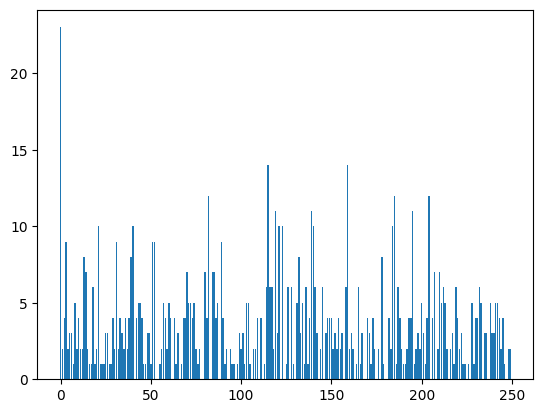

In [64]:
#histogram of bag of words for first image
plt.bar(np.arange(0, len(clusters)), bags[0])